## Imports and dataset

In [1]:
from src.models.optimized_bnn import ClasBayesianNNVI
from src.attacks.distr_attacks_bnn_jax import mlmc_attack
from src.attacks.point_attacks_jax import attack

from src.utils import plot_ppds

import numpy as np
import pandas as pd
import jax
import jax.numpy as jnp
import numpyro
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from joblib import Parallel, delayed

/opt/anaconda3/envs/advReg/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid", palette="muted", font="serif")

sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
plt.rcParams.update({
    'axes.titlesize': 18,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'axes.titleweight': 'bold',
    'axes.edgecolor': 'black',
    'axes.linewidth': 1,
    'grid.alpha': 0.5,
    'grid.linestyle': '--',
    'legend.fontsize': 12,
    'legend.frameon': False,
    'figure.dpi': 300,  
})

In [3]:
import numpyro
numpyro.set_host_device_count(8)

In [4]:
# set all seeds for reproducibility
seed = 42
np.random.seed(seed)

## MNIST - DE

In [5]:
# load MNIST data without tensorflow
from sklearn.datasets import fetch_openml

# Load MNIST from OpenML
mnist = fetch_openml('mnist_784', version=1)
X, y = mnist.data.values, mnist.target.values
X = jnp.array(X) / 255.0  # Normalize pixel values to [0, 1]
y = y.astype(int)
y = jax.nn.one_hot(y, 10)

# Split into training and testing datasets
X_train, X_test = X[:60000], X[60000:]
y_train, y_test = y[:60000], y[60000:]

In [6]:
modelVI = ClasBayesianNNVI(input_dim=X_train.shape[1], hidden_units=10)
try:
    modelVI.load('../src/models/weights/mnist/10bnnvi')
except FileNotFoundError:
    print('Not model found, fitting the model') 
    modelVI.fit(
        X_train, 
        jnp.argmax(y_train, axis=1), 
        num_steps=3000
    )
    modelVI.save('../src/models/weights/mnist/10bnnvi')

In [7]:
modelVI.svi_result.keys()

dict_keys(['auto_cov_factor', 'auto_loc', 'auto_scale'])

In [8]:
# measure accuracy over the test set
y_pred = modelVI.sample_predictive_distribution_probs(jax.random.PRNGKey(0), X_test, 100).mean(axis=0).argmax(axis=-1)
accuracy = (y_pred == jnp.argmax(y_test, axis=1)).mean()
print(f"Accuracy over the test set: {accuracy * 100:.2f}%")

Accuracy over the test set: 76.59%


In [9]:
# Load notMNIST data without labels
import os
from PIL import Image
import numpy as np

# Ruta de la carpeta con imágenes
folder_path = '../data/notMNIST_small'

# Lista para almacenar las imágenes
images = []

for dirpath, dirnames, filenames in os.walk(folder_path):
    for filename in filenames:
        if filename.endswith('.png'):
            img_path = os.path.join(dirpath, filename)
            img = Image.open(img_path)
            img_gray = img.convert('L')
            img_array = np.array(img_gray)
            images.append(img_array)

X_notmnist = np.array(images).reshape(-1, 28*28) / 255.0

In [10]:
def entropy(x, pred):
    pred = pred.mean(axis=0)
    pred += 1e-8
    entr = - (pred * jnp.log(pred)).sum() / jnp.log(2)
    return entr

In [11]:
num_points = 40
epsilons = [.2, .5, 1]

## Baseline

python(33896) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
100%|██████████| 40/40 [00:08<00:00,  4.64it/s]


Text(0.5, 0, 'Entropy')

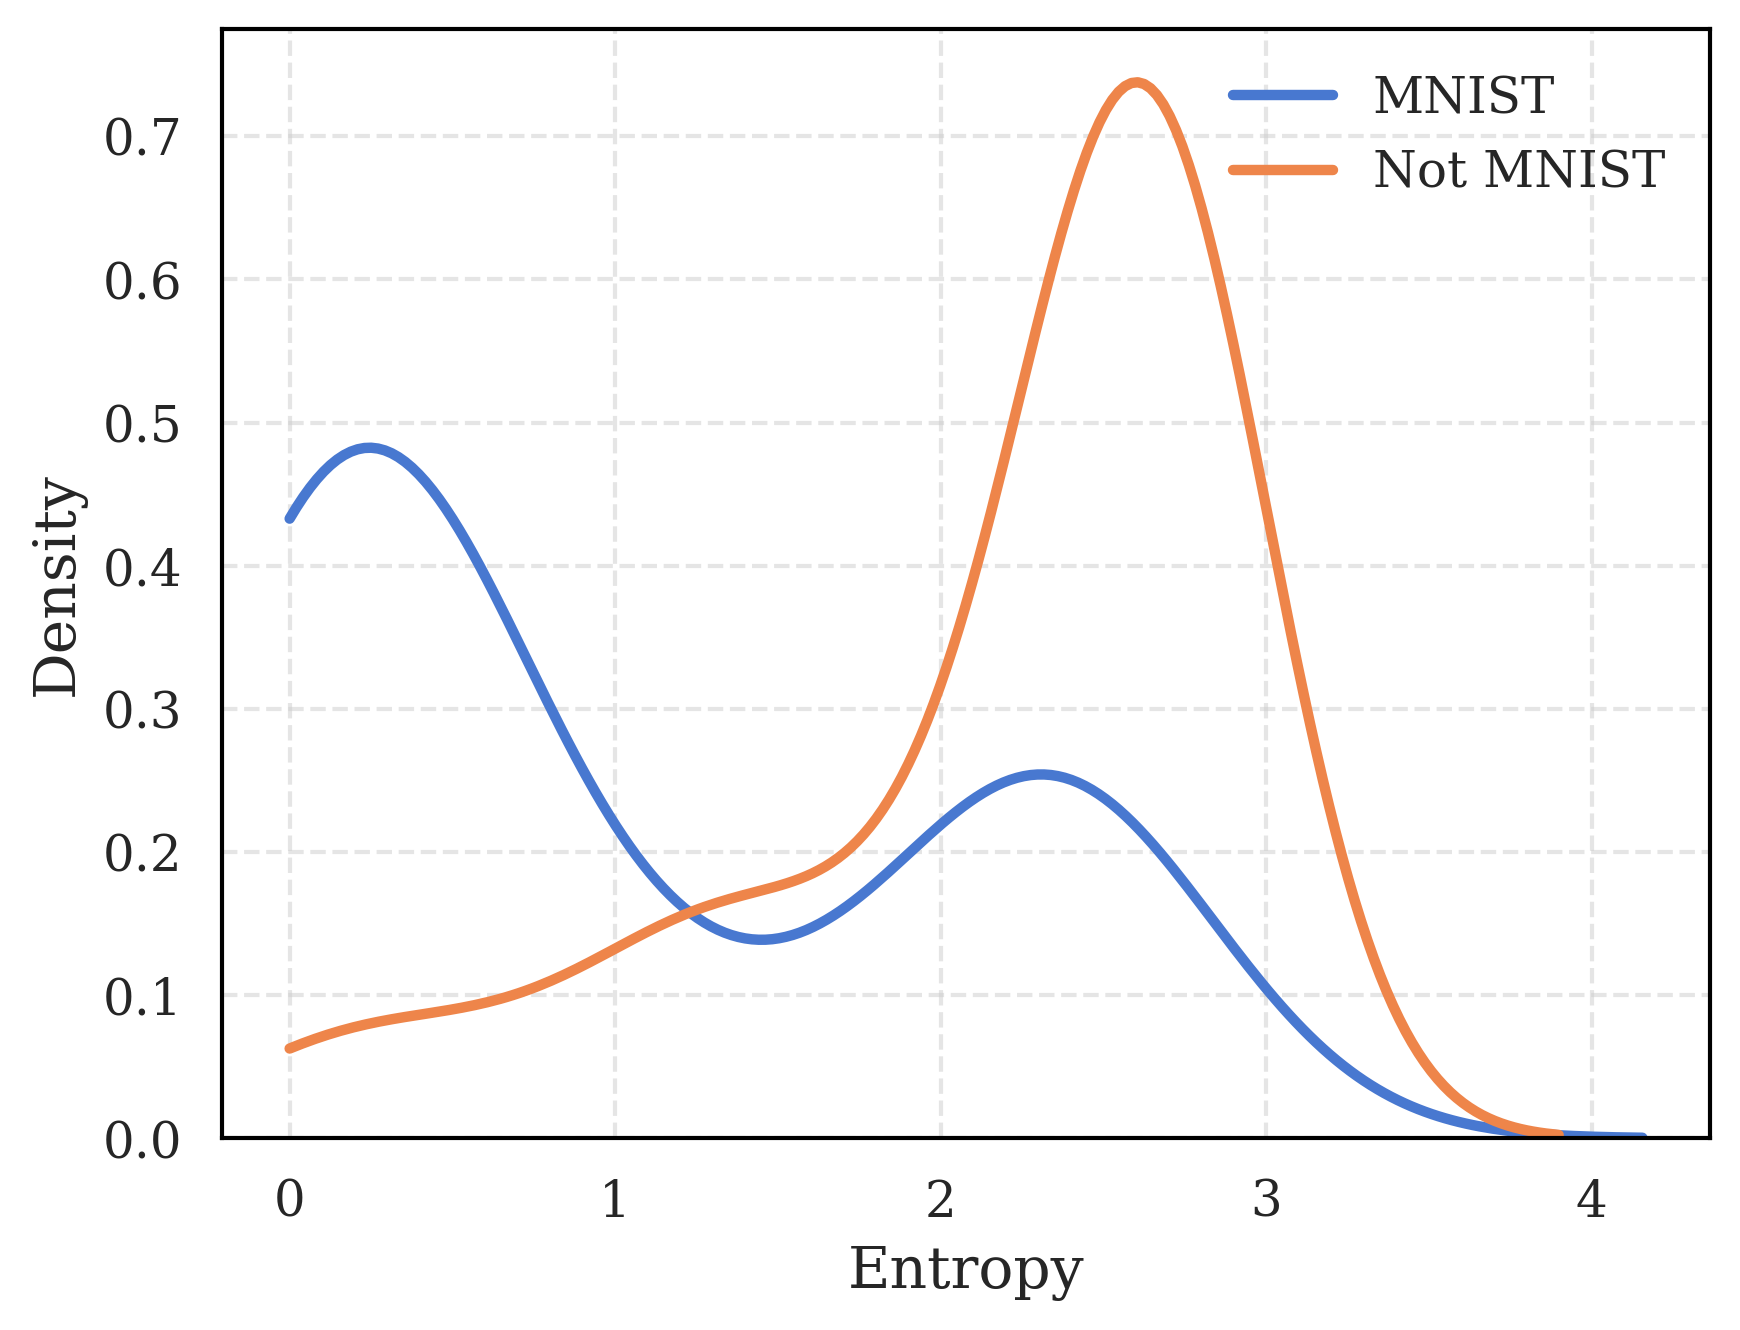

In [12]:
unattacked_entropies = []
for x in tqdm(X_test[:num_points]):
    x = jax.numpy.array(x.reshape(1, -1))
    preds = modelVI.sample_predictive_distribution_probs(jax.random.PRNGKey(0), x, 20)
    unattacked_entropies.append(entropy(x, preds))

sns.kdeplot(jnp.array(unattacked_entropies), clip=(0, 10))
legend = ['MNIST', 'Not MNIST']
unattacked_entropies = []
for x in tqdm(X_notmnist[:num_points]):
    x = jax.numpy.array(x.reshape(1, -1))
    preds = modelVI.sample_predictive_distribution_probs(jax.random.PRNGKey(0), x, 20)
    unattacked_entropies.append(entropy(x, preds))

sns.kdeplot(jnp.array(unattacked_entropies), clip=(0, 10))
plt.legend(legend)
plt.xlabel('Entropy')

## Point attacks

100%|██████████| 40/40 [01:06<00:00,  1.67s/it]


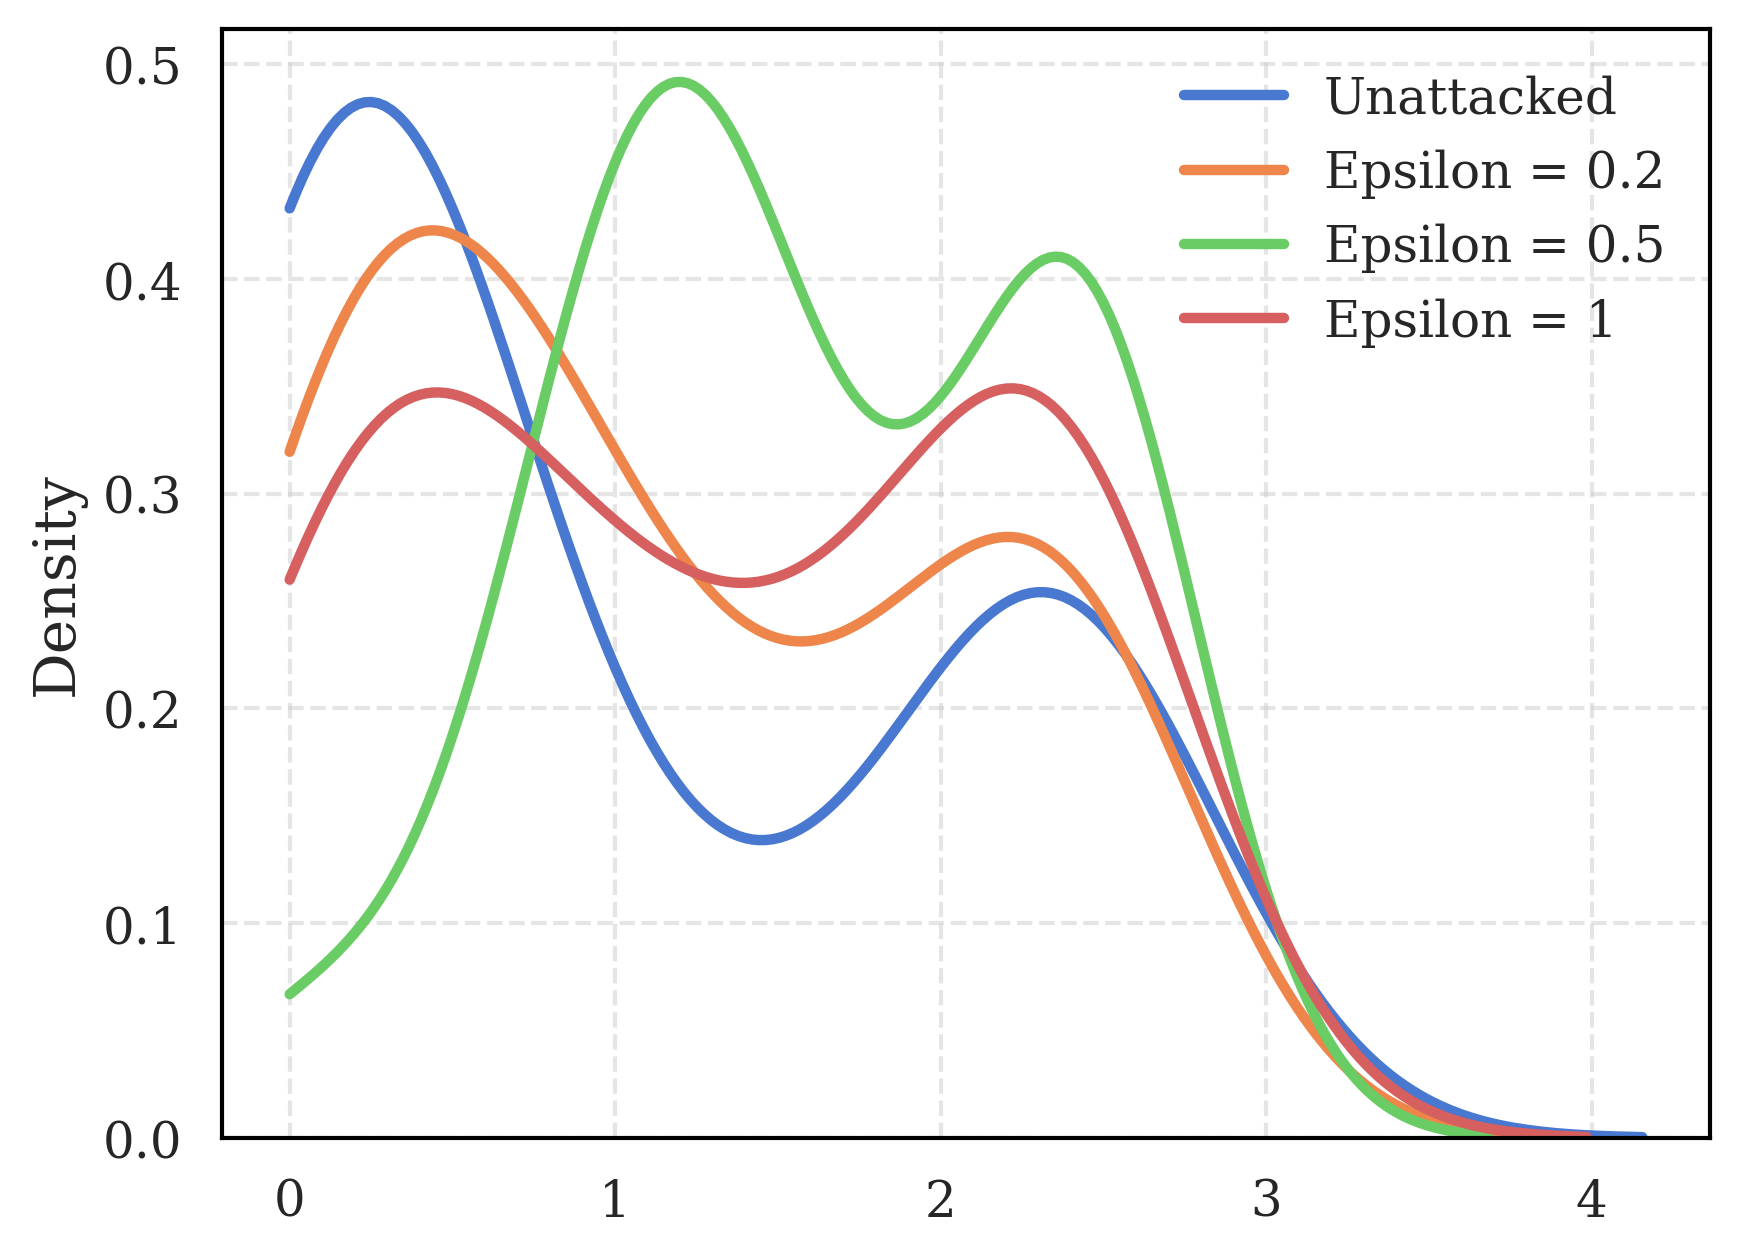

In [13]:
G = 2  # we want to rise the entropy of the predictive distribution

def process(x, eps):
    x = jax.numpy.array(x.reshape(1, -1))
    x_adv_values, loss_values, func_values = attack(x, modelVI, G, func=entropy, samples_per_iteration=1000, epsilon=eps, num_iterations=1000, learning_rate=0.01, mnist_vi=True)
    preds = modelVI.sample_predictive_distribution_probs(jax.random.PRNGKey(0), x_adv_values[-1], 20)
    return entropy(x_adv_values[-1], preds)

unattacked_entropies = []
for x in tqdm(X_test[:num_points]):
    x = jax.numpy.array(x.reshape(1, -1))
    preds = modelVI.sample_predictive_distribution_probs(jax.random.PRNGKey(0), x, 20)
    unattacked_entropies.append(entropy(x, preds))
sns.kdeplot(jnp.array(unattacked_entropies), clip=(0, 10))  

entropies_point_rise = []
for eps in epsilons:
    #entropies = Parallel(n_jobs=8)(delayed(process)(x, eps) for x in tqdm(X_test[:num_points]))
    entropies = [process(x, eps) for x in tqdm(X_test[:num_points])]
    sns.kdeplot(jnp.array(entropies), clip=(0, 10))
    entropies_point_rise.append(jnp.array(entropies))
np.save('results/entropies_point_rise.npy', jnp.array(entropies_point_rise))
    
legend = ['Unattacked'] + ['Epsilon = ' + str(eps) for eps in epsilons]
plt.legend(legend)

100%|██████████| 40/40 [01:08<00:00,  1.71s/it]


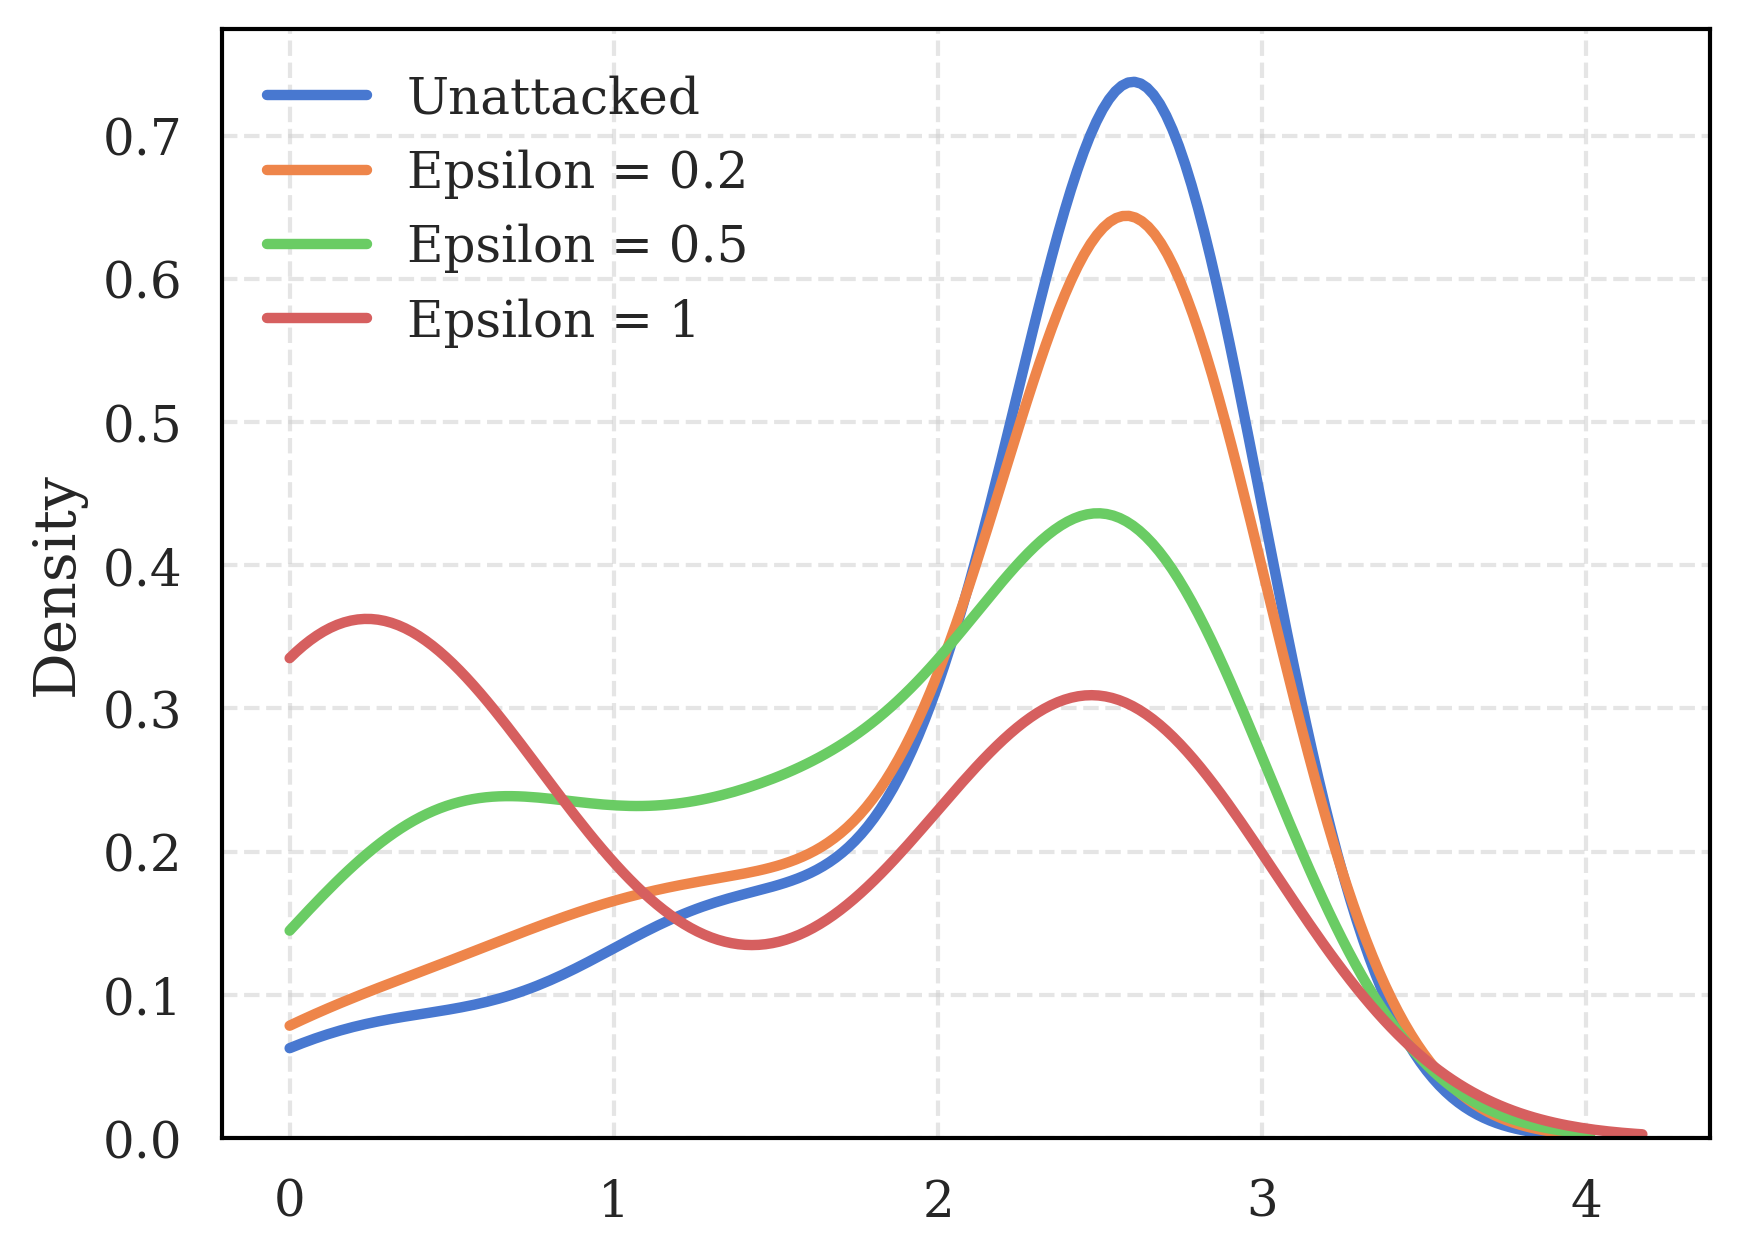

In [14]:
G = 0  # we want to lower the entropy of the predictive distribution

def process(x, eps):
    x = jax.numpy.array(x.reshape(1, -1))
    x_adv_values, loss_values, func_values = attack(x, modelVI, G, func=entropy, samples_per_iteration=1000, epsilon=eps, num_iterations=1000, learning_rate=0.01, mnist_vi=True)
    preds = modelVI.sample_predictive_distribution_probs(jax.random.PRNGKey(0), x_adv_values[-1], 20)
    return entropy(x_adv_values[-1], preds)

unattacked_entropies = []
for x in tqdm(X_notmnist[:num_points]):
    x = jax.numpy.array(x.reshape(1, -1))
    preds = modelVI.sample_predictive_distribution_probs(jax.random.PRNGKey(0), x, 20)
    unattacked_entropies.append(entropy(x, preds))
sns.kdeplot(jnp.array(unattacked_entropies), clip=(0, 10))

entropies_point_lower = []
for eps in epsilons:
    #entropies = Parallel(n_jobs=8)(delayed(process)(x, eps) for x in tqdm(X_test[:num_points]))
    entropies = [process(x, eps) for x in tqdm(X_notmnist[:num_points])]
    sns.kdeplot(jnp.array(entropies), clip=(0, 10))
    entropies_point_lower.append(jnp.array(entropies))
np.save('results/entropies_point_lower.npy', jnp.array(entropies_point_lower))

legend = ['Unattacked'] + ['Epsilon = ' + str(eps) for eps in epsilons]
plt.legend(legend)

## Distribution attacks

100%|██████████| 40/40 [00:16<00:00,  2.38it/s]


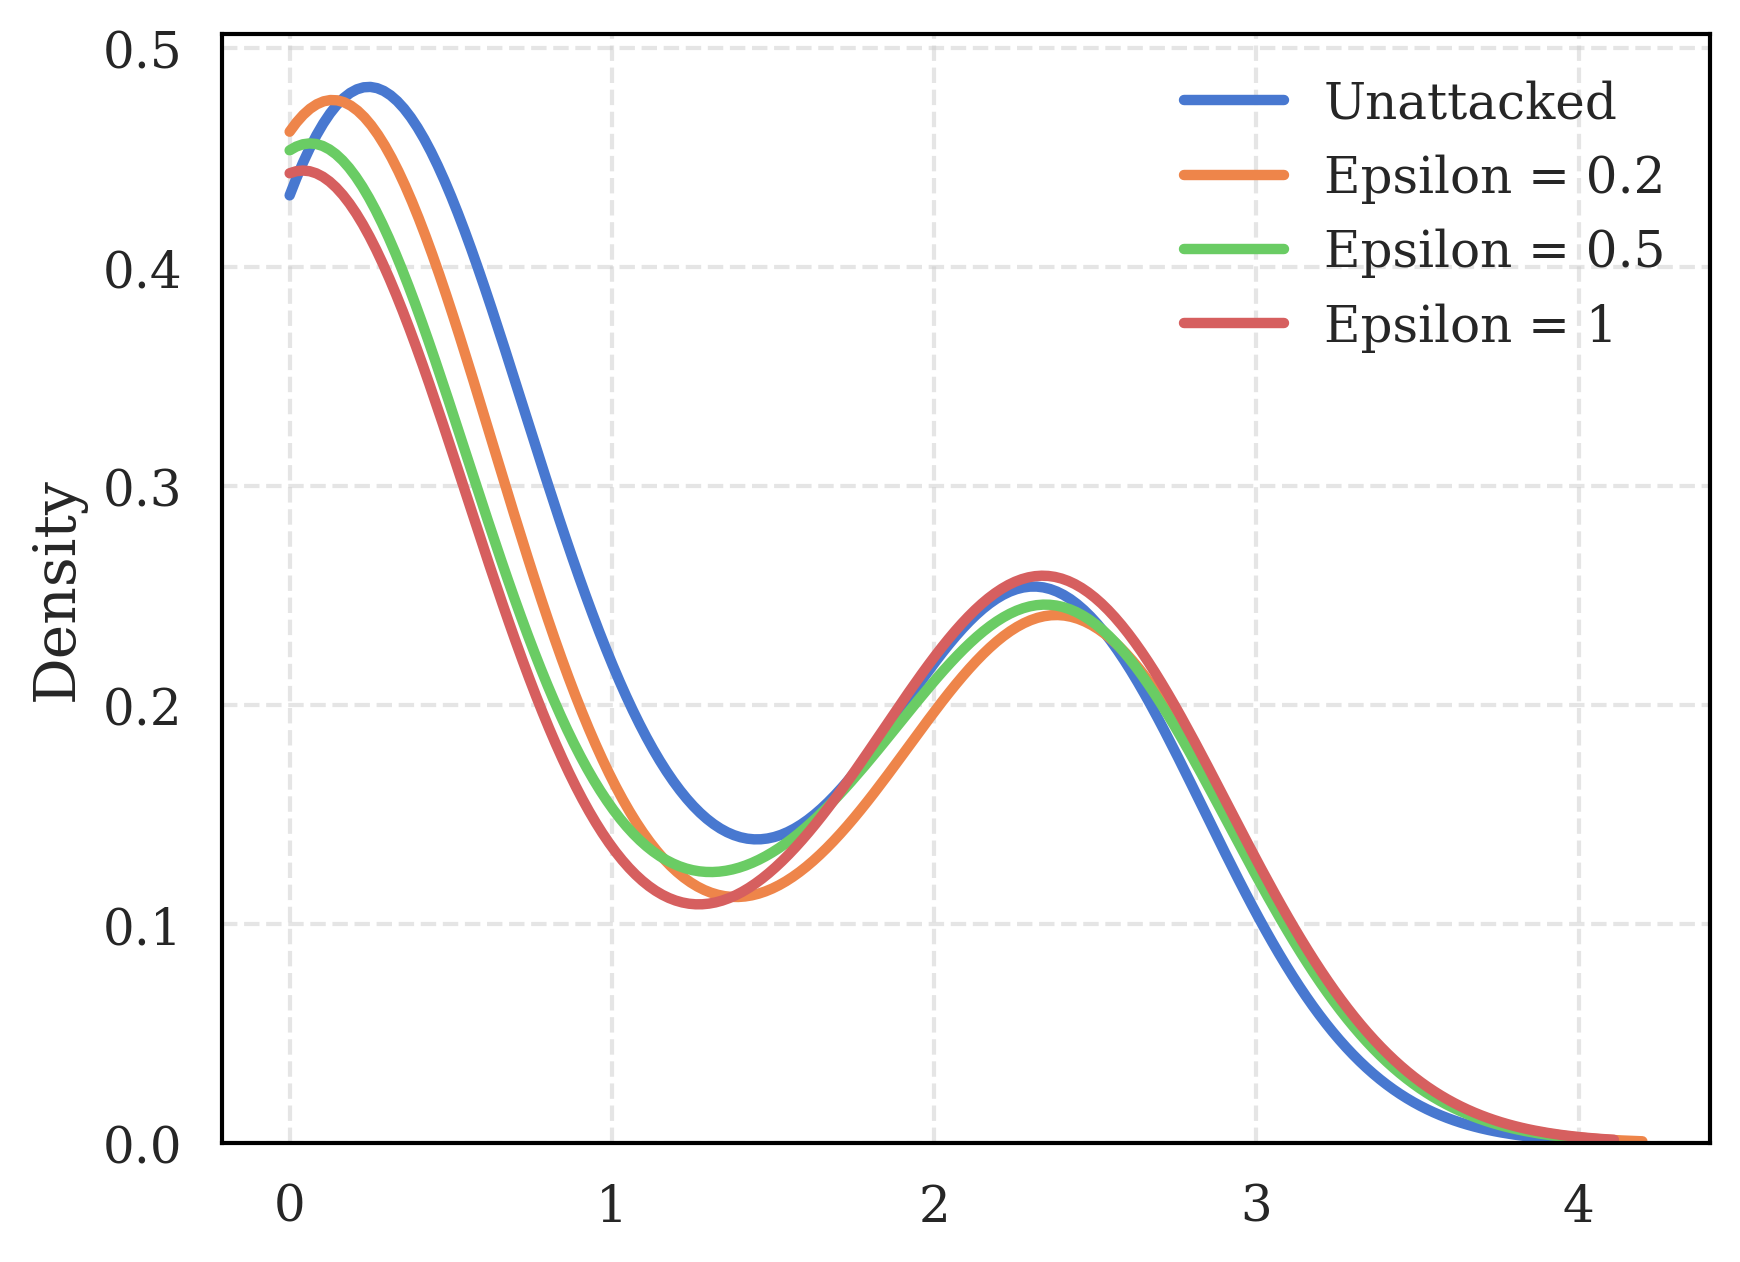

In [15]:
# Y is a uniform distribution over 10 classes
obj_appd = numpyro.distributions.Categorical(jnp.ones(10) / 10)

def process(x, eps):
    x = jax.numpy.array(x.reshape(1, -1))
    x_adv, _ = mlmc_attack(modelVI, x, appd=obj_appd, epsilon=eps, n_iter=400, lr=0.01)  # TODO DIFFERENT LR???
    preds = modelVI.sample_predictive_distribution_probs(jax.random.PRNGKey(0), x_adv, 20)
    return entropy(x_adv, preds)

unattacked_entropies = []
for x in tqdm(X_test[:num_points]):
    x = jax.numpy.array(x.reshape(1, -1))
    preds = modelVI.sample_predictive_distribution_probs(jax.random.PRNGKey(0), x, 20)
    unattacked_entropies.append(entropy(x, preds))
sns.kdeplot(jnp.array(unattacked_entropies), clip=(0, 10))

entropies_dist_rise = []
for eps in epsilons:
    #entropies = Parallel(n_jobs=4)(delayed(process)(x, eps) for x in tqdm(X_test[:80]))
    entropies = [process(x, eps) for x in tqdm(X_test[:num_points])]
    sns.kdeplot(jnp.array(entropies), clip=(0, 10))
    entropies_dist_rise.append(jnp.array(entropies))
np.save('results/entropies_dist_rise.npy', jnp.array(entropies_dist_rise))
    
legend = ['Unattacked'] + ['Epsilon = ' + str(eps) for eps in epsilons]
plt.legend(legend)

100%|██████████| 40/40 [00:16<00:00,  2.36it/s]


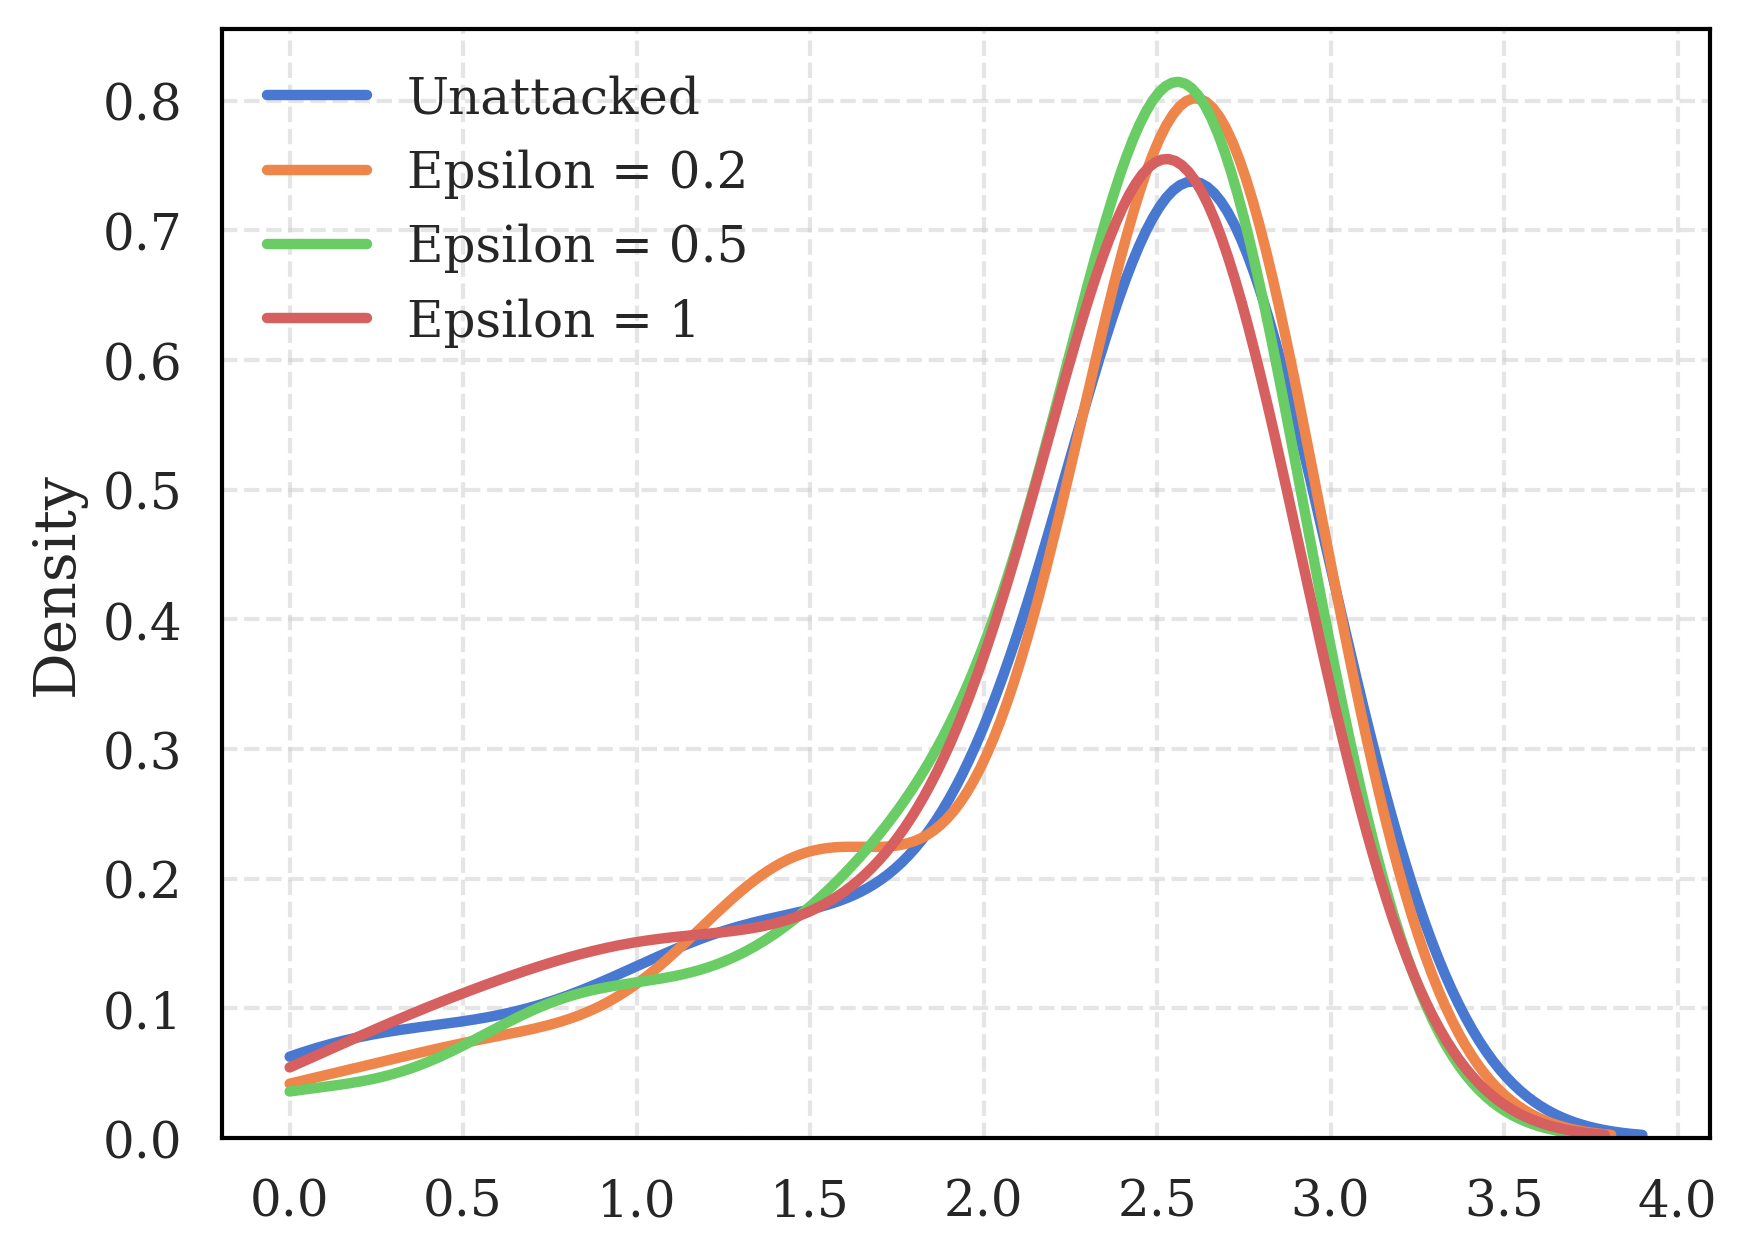

In [16]:
def process(x, eps):
    x = jax.numpy.array(x.reshape(1, -1))
    pred = modelVI.sample_predictive_distribution(jax.random.PRNGKey(0), x, 1)  # so obj_appd is just 1 point mass on pred
    obj_appd = numpyro.distributions.Categorical(probs=jax.nn.one_hot(pred, 10))
    
    x_adv, _ = mlmc_attack(modelVI, x, appd=obj_appd, epsilon=eps, n_iter=400)
    preds = modelVI.sample_predictive_distribution_probs(jax.random.PRNGKey(0), x_adv, 20)
    return entropy(x_adv, preds)

unattacked_entropies = []
for x in tqdm(X_notmnist[:num_points]):
    x = jax.numpy.array(x.reshape(1, -1))
    preds = modelVI.sample_predictive_distribution_probs(jax.random.PRNGKey(0), x, 20)
    unattacked_entropies.append(entropy(x, preds))
sns.kdeplot(jnp.array(unattacked_entropies), clip=(0, 10))

entropies_dist_lower = []
for eps in epsilons:
    #entropies = Parallel(n_jobs=4)(delayed(process)(x, eps) for x in tqdm(X_notmnist[:8]))  # TODO 80 points
    entropies = [process(x, eps) for x in tqdm(X_notmnist[:num_points])]
    sns.kdeplot(jnp.array(entropies), clip=(0, 10))
    entropies_dist_lower.append(jnp.array(entropies))
np.save('results/entropies_dist_lower.npy', jnp.array(entropies_dist_lower))

legend = ['Unattacked'] + ['Epsilon = ' + str(eps) for eps in epsilons]
plt.legend(legend)

## Security eval plot

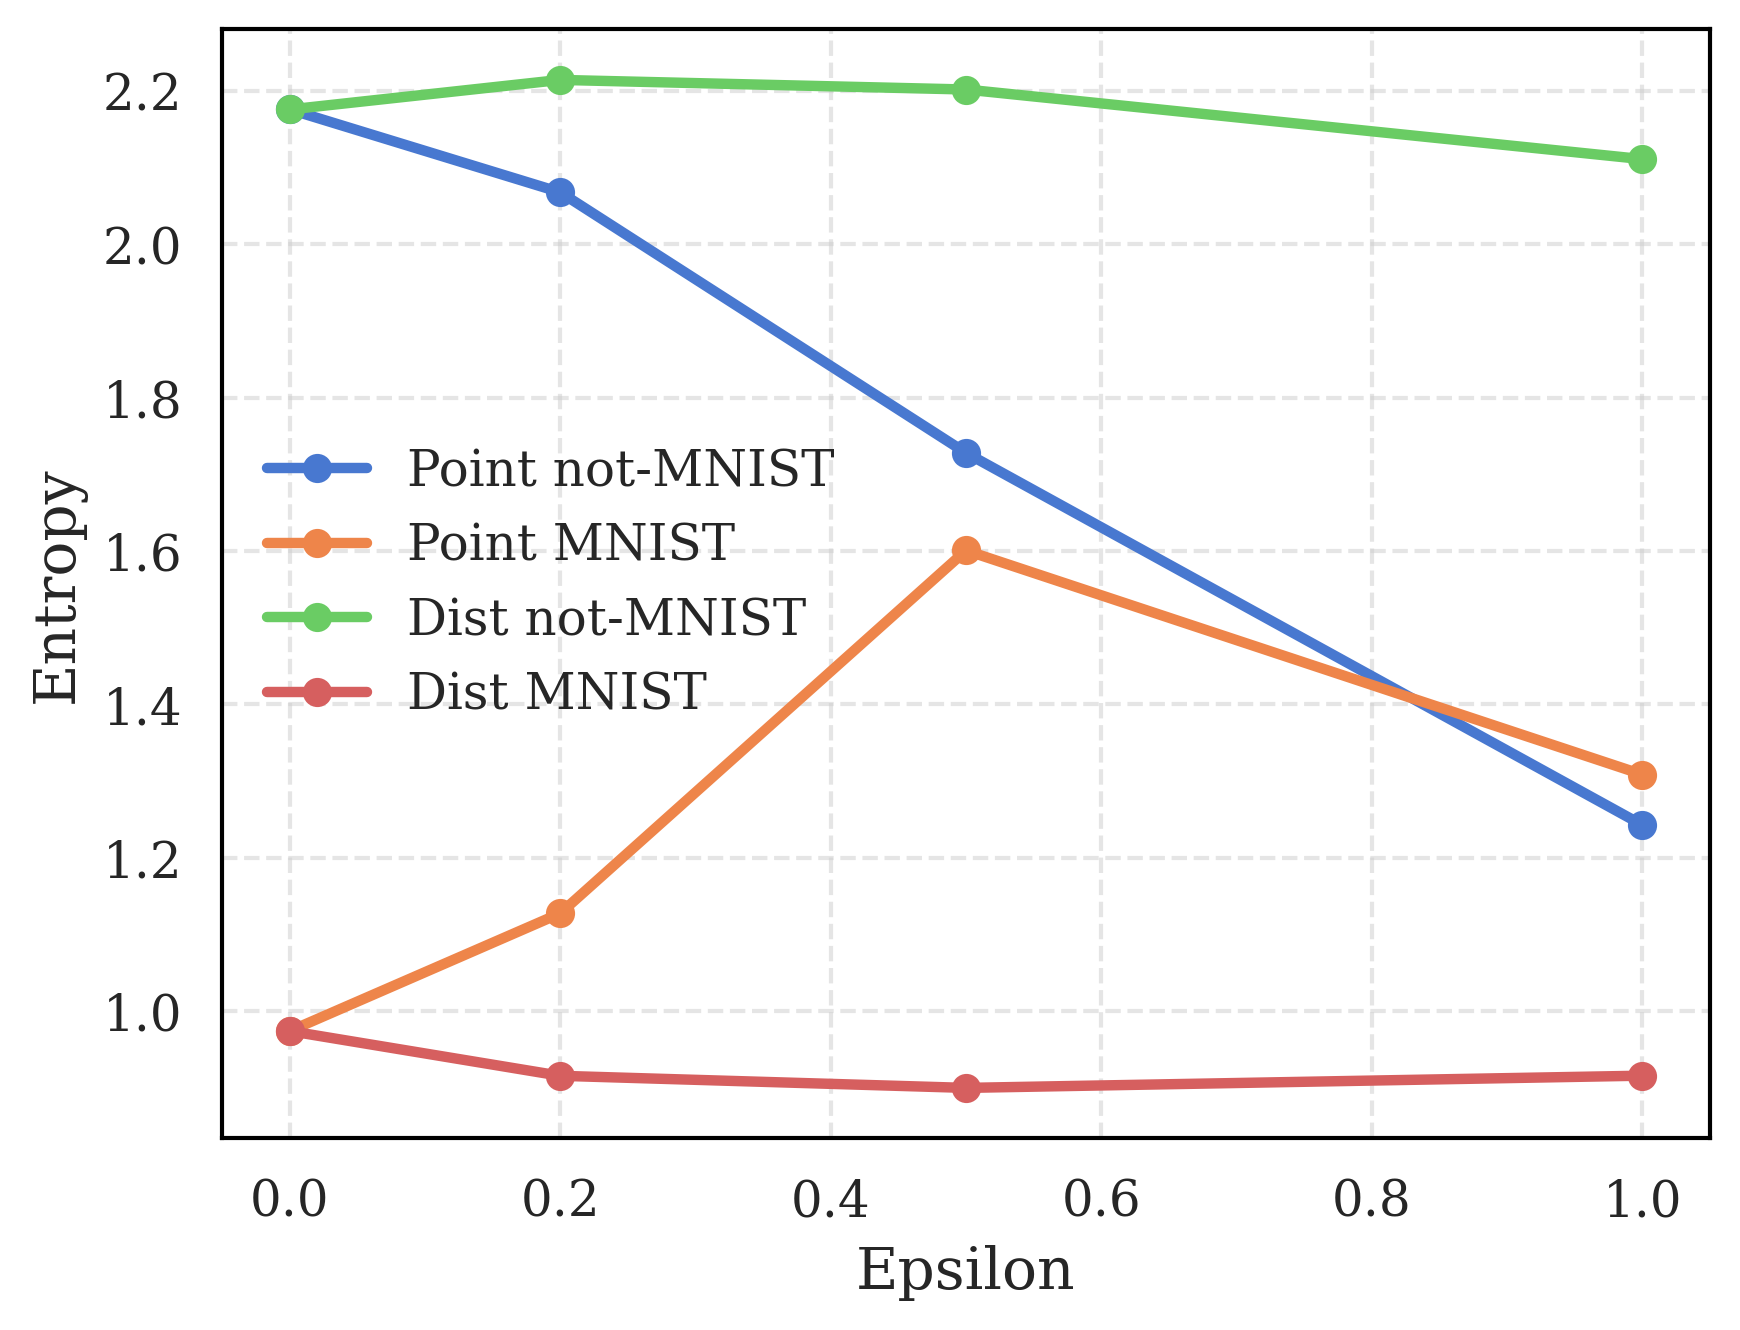

In [17]:
entropies_point_lower = np.load('results/entropies_point_lower.npy')
entropies_point_rise = np.load('results/entropies_point_rise.npy')
entropies_dist_lower = np.load('results/entropies_dist_lower.npy')
entropies_dist_rise = np.load('results/entropies_dist_rise.npy')

entropies_point_lower_mean = entropies_point_lower.mean(axis=1)
entropies_point_rise_mean = entropies_point_rise.mean(axis=1)
entropies_dist_lower_mean = entropies_dist_lower.mean(axis=1)
entropies_dist_rise_mean = entropies_dist_rise.mean(axis=1)

zero_eps_entropy = np.array([entropy(x, modelVI.sample_predictive_distribution_probs(jax.random.PRNGKey(0), x, 20)) for x in X_test[:num_points]]).mean()
zero_eps_entropy_notmnist = np.array([entropy(x, modelVI.sample_predictive_distribution_probs(jax.random.PRNGKey(0), x, 20)) for x in X_notmnist[:num_points]]).mean()

entropies_point_lower_mean = np.concatenate([[zero_eps_entropy_notmnist], entropies_point_lower_mean])
entropies_point_rise_mean = np.concatenate([[zero_eps_entropy], entropies_point_rise_mean])
entropies_dist_lower_mean = np.concatenate([[zero_eps_entropy_notmnist], entropies_dist_lower_mean])
entropies_dist_rise_mean = np.concatenate([[zero_eps_entropy], entropies_dist_rise_mean])
epsilons_full = np.concatenate([[0], epsilons])

plt.plot(epsilons_full, entropies_point_lower_mean, marker='o')
plt.plot(epsilons_full, entropies_point_rise_mean, marker='o')
plt.plot(epsilons_full, entropies_dist_lower_mean, marker='o')
plt.plot(epsilons_full, entropies_dist_rise_mean, marker='o')
plt.legend(['Point not-MNIST', 'Point MNIST', 'Dist not-MNIST', 'Dist MNIST'])
plt.xlabel('Epsilon')
plt.ylabel('Entropy')
plt.show()